In [1]:
%matplotlib inline
import numpy as np
import os

# Increasing synaptic recruitment in a dendritic branch

We increase the number of synapses recruited in a localized region of the dendritic tree

INFO       Cache size for target "cython": 2688 MB.
You can call "clear_cache('cython')" to delete all files from the cache or manually delete files in the "/home/yann/.cython/brian_extensions" directory. [brian2]


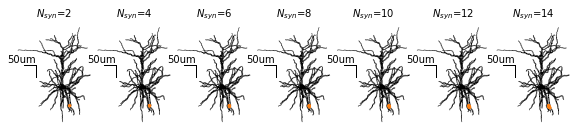

In [2]:
%run nmda-spike syn-demo

## $V_m$ response to increasing synaptic recruitment

In [3]:
%run nmda-spike run-demo

In [3]:
%run nmda-spike demo-plot

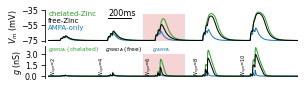

In [32]:
from datavyz import ge
fig2, AX = ge.figure(axes=(1,2), figsize=(2.,.7), hspace=0.2)

for i, key, color in zip(range(3), ['AMPA-only', 'chelated-Zinc', 'free-Zinc'],
                         [ge.blue, ge.green, 'k']):
    data = np.load(os.path.join('data','nmda-spike','demo-%s.npy' % key), allow_pickle=True).item()
    AX[0].plot(data['t'], data['Vm_soma'], color=color, label=key, lw=1)
    AX[1].plot(data['t'], data['gNMDA_syn'], color=color, lw=1)
L=0
for i, key, color, l in zip(range(3),
                            ['chelated-Zinc', 'free-Zinc', 'AMPA-only'],
                            [ge.green, 'k', ge.blue],
                            ['$g_{NMDA}$ (chelated)', '$g_{NMDA}$ (free)', '$g_{AMPA}$']):
    ge.annotate(AX[0],i*'\n'+key, (0,1), va='top', color=color, bold=False, size='small')
    ge.annotate(AX[1],int(1.45*L)*' '+l, (0,3.), color=color, bold=False, size='x-small', xycoords='data')
    L+=len(l)
    
AX[0].fill_between([800,1150], [-75,-75],[-40,-40], color=ge.red, alpha=.2, lw=0)
AX[1].fill_between([800,1150], [0,0],[3,3], color=ge.red, alpha=.2, lw=0)

for e, n in zip(data['events'], data['NSYNs']):
    ge.annotate(AX[1], ' $N_{syn}$=%i' % n, (e, 0),
                xycoords='data', rotation=90, ha='right', size='xx-small')
ge.draw_bar_scales(AX[0], Xbar=200, Xbar_label='200ms', Ybar=1e-12, xyLoc=(500,-45))
# ge.legend(AX[1], size='x-small', ncol=3, loc=(0.,.7))
ge.set_plot(AX[0], ['left'], ylabel='$V_m$ (mV)', xlim=[data['t'][0], data['t'][-1]], yticks=[-75, -55, -35])
ge.set_plot(AX[1], ['left'], ylabel='$g$ (nS)', xlim=[data['t'][0], data['t'][-1]])

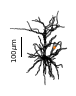

In [31]:
loc_syn0 = LOCs[9]

from datavyz import nrnvyz
_, neuron, SEGMENTS = initialize_sim(Model)
vis = nrnvyz(SEGMENTS, ge=ge)
        
fig1, ax = ge.figure(figsize=(1.2,1.8), wspace=0, left=0, top=0.3, bottom=0, right=0)

ax.plot([-130, -130], [10, 110], 'k-', lw=1) 
ge.annotate(ax, '100$\mu$m', (-135, 110), va='top', ha='right', rotation=90, xycoords='data', size='small')
vis.plot_segments(SEGMENTS['comp_type']!='axon',
                  bar_scale_args=None,
                  ax=ax)
vis.add_dots(ax, loc_syn0+np.arange(1), 7, ge.orange)

In [11]:
#
def get_integral_after_third_pulse(loc, NSYNs=None,
                                   integral_interval=[40, 100]):
    """
    
    """
    data0 = np.load('data/nmda-spike/data-loc-%i-AMPA-only.npy' % loc, allow_pickle=True).item()
    if NSYNs is None:
        NSYNs = np.sort(np.unique(data0['NSYNs']))
    data1 = np.load('data/nmda-spike/data-loc-%i-chelated-Zinc.npy' % loc, allow_pickle=True).item()
    data2 = np.load('data/nmda-spike/data-loc-%i-free-Zinc.npy' % loc, allow_pickle=True).item()
    area0, area1, area2 = 0*NSYNs, 0*NSYNs, 0*NSYNs
    for i in range(len(NSYNs)):
        insyn = np.argwhere(data0['NSYNs']==NSYNs[i])[0][0]
        Third_pulse_cond = (data0['t']>data0['events'][insyn]+integral_interval[0]) &\
                                (data0['t']<data0['events'][insyn]+integral_interval[1])
        area0[i] = np.trapz(data0['Vm_soma'][Third_pulse_cond]+75, x=data0['t'][Third_pulse_cond])
        area1[i] = np.trapz(data1['Vm_soma'][Third_pulse_cond]+75, x=data0['t'][Third_pulse_cond])
        area2[i] = np.trapz(data2['Vm_soma'][Third_pulse_cond]+75, x=data0['t'][Third_pulse_cond])
    return NSYNs, area0, area1, area2


def get_max_depol_response(loc, NSYNs=None,
                     max_interval=[0, 100]):
 
    data0 = np.load('data/nmda-spike/data-loc-%i-AMPA-only.npy' % loc, allow_pickle=True).item()
    if NSYNs is None:
        NSYNs = np.sort(np.unique(data0['NSYNs']))
    data1 = np.load('data/nmda-spike/data-loc-%i-chelated-Zinc.npy' % loc, allow_pickle=True).item()
    data2 = np.load('data/nmda-spike/data-loc-%i-free-Zinc.npy' % loc, allow_pickle=True).item()
    depol0, depol1, depol2 = 0*NSYNs, 0*NSYNs, 0*NSYNs
    for i in range(len(NSYNs)):
        insyn = np.argwhere(data0['NSYNs']==NSYNs[i])[0][0]
        max_cond = (data0['t']>data0['events'][insyn]+max_interval[0]) &\
        (data0['t']<data0['events'][insyn]+max_interval[1])
        depol0[i] = np.max(data0['Vm_soma'][max_cond])
        depol1[i] = np.max(data1['Vm_soma'][max_cond])
        depol2[i] = np.max(data2['Vm_soma'][max_cond])
    return NSYNs, depol0, depol1, depol2


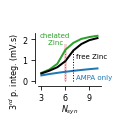

In [34]:
from datavyz import ge
fig3, ax = ge.figure(figsize=(1.,1.1))

NSYNs = np.arange(3,11)
NSYNs, x0, x1, x2 = get_integral_after_third_pulse(LOCs[9], NSYNs=NSYNs)
ylabel = 'Integral (mV.s)    '
x0, x1, x2 = x0/1e3, x1/1e3, x2/1e3
i1 = np.argmax(np.diff(x1))+1
i2 = np.argmax(np.diff(x2))+1

ge.plot(NSYNs ,Y=[x0, x1, x2], ax=ax, no_set=True, COLORS=[ge.blue, ge.green, 'k'], lw=2)
ax.plot([NSYNs[i1], NSYNs[i1]] , [0, x1[i1]], ':', color=ge.green, lw=1)
ax.plot([NSYNs[i2], NSYNs[i2]] , [0, x2[i2]], ':', color='k', lw=1)
ge.annotate(ax, 'AMPA only', (0.6, 0.05), color=ge.blue, size='small')
ge.annotate(ax, 'chelated\n    Zinc', (0.02, 0.75), color=ge.green, size='small')
ge.annotate(ax, 'free Zinc', (0.6, 0.47), color='k', size='small')
ax.fill_between([5.8,6.2], [0,0], 1.8*np.ones(2), color=ge.red, alpha=.2, lw=0)
    
ge.set_plot(ax, ylabel='3$^{rd}$ p. integ. (mV.s)           ', xlabel='$N_{syn}$', xticks=[3,6,9], yticks=[0,1,2])

In [36]:
ge.multipanel_figure([[fig1, fig2, fig3]],
                     LABELS=[['a', 'b', 'c']],
                     width='double-column',# mm
                     X = [[-15, 20, 350]],
                     Y = [[-5, 5, -10]],
                     X_LABELS = [[0, 90, 370]], Y_LABELS = [[0,0,0]],
                     height=33, # mm
                     export_to_png=True, bg='white',
                     fig_name=os.path.join('figures', 'nmda-event.svg'))

RUNNING: inkscape figures\nmda-event.svg --export-area-page --export-background="white" --export-type=png --export-filename="figures\nmda-event.png" --export-dpi=300
[ok] figure successfully exported as: figures\nmda-event.png


# Running this simulation across different dendritic locations 

The 25 locations are defined as a set of segments:
   - being at least 50um far from the soma
   - being adjacent to each other (i.e. remaining on the same branch)
   
We build those 25 locations by picking random segments on the branch, we check if the next 50 segments fullfill the distance and adjancency conditions, if yes, the resulting set of segments makes one "location". We show below the set of locations generated (color-coded)

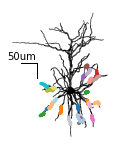

25 segments


<Figure size 432x288 with 0 Axes>

In [37]:
%run nmda-spike locations

## Response data across all dendritic locations 

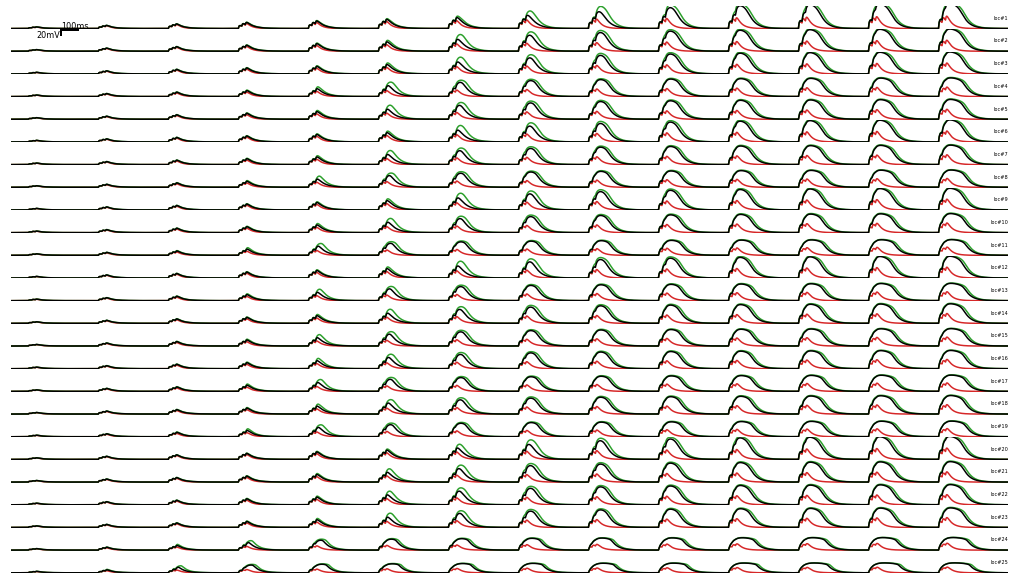

In [127]:
fig, AX = ge.figure(axes=(1, len(LOCs)), figsize=(4,.5), hspace=0)
for i, loc in enumerate(LOCs):
    data = np.load('data/nmda-spike/data-loc-%i-AMPA-only.npy' % loc, allow_pickle=True).item()
    AX[i].plot(data['t'], data['Vm_soma'], color=ge.red)
    data = np.load('data/nmda-spike/data-loc-%i-chelated-Zinc.npy' % loc, allow_pickle=True).item()
    AX[i].plot(data['t'], data['Vm_soma'], color=ge.green)
    data = np.load('data/nmda-spike/data-loc-%i-free-Zinc.npy' % loc, allow_pickle=True).item()
    AX[i].plot(data['t'], data['Vm_soma'], color='k')
    ge.annotate(AX[i], 'loc#%i' % (i+1), (1.,.4), size='xx-small', ha='right')
    ge.set_plot(AX[i], [], xlim=[data['t'][0], data['t'][-1]], ylim=[-76, -30])
ge.draw_bar_scales(AX[1], Xbar=100, Ybar=10, loc='left-top', Xbar_label='100ms', Ybar_label='20mV', lw=2)

# Now summarizing those data

In [40]:
def plot_nmda_effect(loc=5,
                     method='peak-Vm',
                     NSYNs = None,
                     ax=None):
    
    if ax is None:
        fig, ax = ge.figure()
    
    if method=='integral':
        NSYNs, x0, x1, x2 = get_integral_after_third_pulse(LOCs[loc], NSYNs=NSYNs)
        ylabel = 'Integral (mV.s)    '
        x0, x1, x2 = x0/1e3, x1/1e3, x2/1e3
    if method=='derivative':
        NSYNs, x0, x1, x2 = get_integral_after_third_pulse(LOCs[loc], NSYNs=NSYNs)
        NSYNs, x0, x1, x2 = .5*(NSYNs[1:]+NSYNs[:-1]), np.diff(x0), np.diff(x1), np.diff(x2)
        ylabel = 'Integral deriv. (mV)    '
    elif method=='peak-Vm':
        NSYNs, x0, x1, x2 = get_max_depol_response(LOCs[loc], NSYNs=NSYNs)
        ylabel = 'peak $V_m$ (mV)    '
        
    ge.plot(NSYNs ,Y=[x0, x1, x2], ax=ax, no_set=True, COLORS=[ge.blue, ge.green, 'k'], lw=2)
    ge.annotate(ax, 'AMPA only', (0.4, 0.05), color=ge.blue, size='small', bold=True)
    ge.annotate(ax, 'chelated\n    Zinc', (0.02, 0.7), color=ge.green, size='small', bold=True)
    ge.annotate(ax, 'free Zinc', (0.52, 0.45), color='k', size='small', bold=True)
    #ge.title(ax, 'NMDA-mediated effect')
    ge.set_plot(ax, ylabel=ylabel, xlabel='# act. synapses, $N_{syn}$    ')
    

# Peak Response

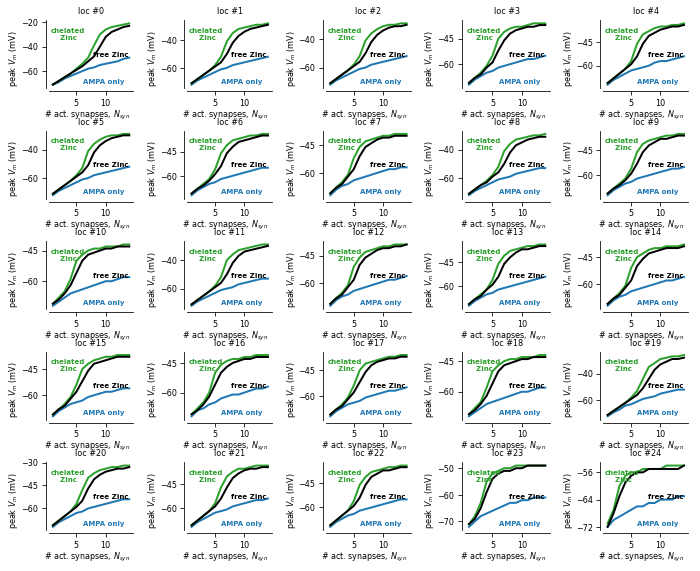

In [126]:
locs = range(25)
_, AX = ge.figure(axes=(5,5), figsize=(1.2,1.5))

for loc, ax in zip(locs, ge.flat(AX)):
    ge.title(ax, 'loc #%i' % loc)
    plot_nmda_effect(loc=loc, ax=ax)

# Integral Response

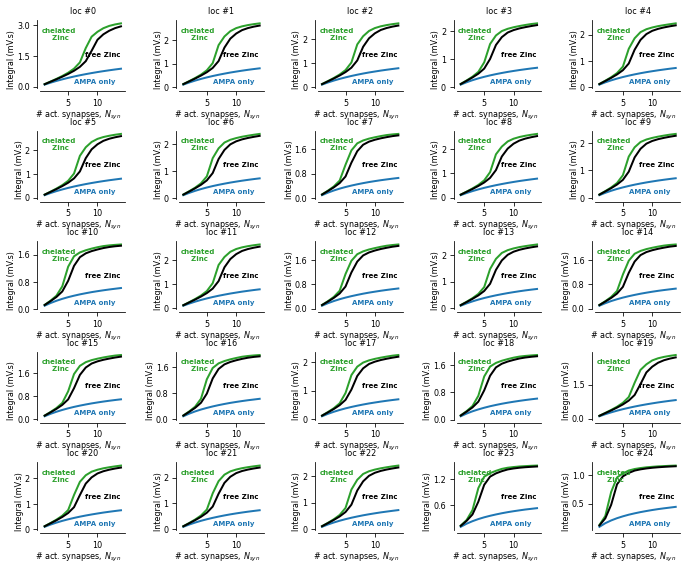

In [78]:
locs = range(25)
_, AX = ge.figure(axes=(5,5), figsize=(1.2,1.5))

for loc, ax in zip(locs, ge.flat(AX)):
    ge.title(ax, 'loc #%i' % loc)
    plot_nmda_effect(loc=loc, ax=ax, method='integral')

# Derivative-based estimate of FWHM

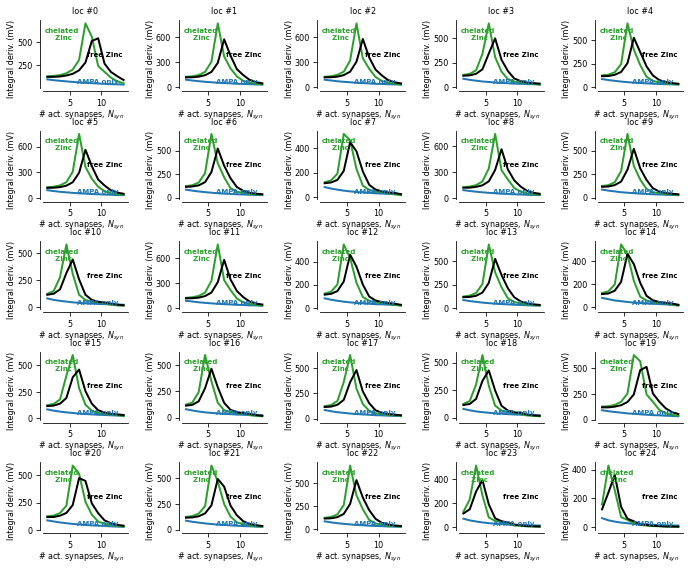

In [105]:
locs = range(25)
_, AX = ge.figure(axes=(5,5), figsize=(1.2,1.5))

FWHM, HML = {}, {}
for key in ['AMPA', 'freeZn', 'chelatedZn']:
    FWHM[key] = [] # full-width-half-maximum
    HML[key] = [] # half-maximum level
    
for loc, ax in zip(locs, ge.flat(AX)):
    ge.title(ax, 'loc #%i' % loc)
    
    plot_nmda_effect(loc=loc, ax=ax, method='derivative')
    
    NSYNs, x0, x1, x2 = get_integral_after_third_pulse(LOCs[loc])
    i1 = np.argmax(np.diff(x1))+1
    FWHM['chelatedZn'].append(NSYNs[i1])
    HML['chelatedZn'].append(x1[i1])
    i2 = np.argmax(np.diff(x2))+1
    FWHM['freeZn'].append(NSYNs[i2])
    HML['freeZn'].append(x2[i1])


In [77]:
from scipy.stats import ttest_rel

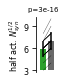

In [137]:
from datavyz import ge

first_observations = np.array(FWHM['chelatedZn'])-3
second_observations = np.array(FWHM['freeZn'])-3
color1=ge.green
color2='dimgrey'
lw=0.3
ylabel='half act. $N_{syn}^{1/2}$'
fig_args={'figsize':(.5,1.2)}
xticks_rotation=70

pval = ttest_rel(first_observations, second_observations)[1]

fig4, ax = ge.figure(**fig_args)
    
for i in range(len(first_observations)):
    ax.plot([0, 1], [first_observations[i], second_observations[i]], '-', lw=lw, color='k')
    
ax.bar([0], [np.mean(first_observations)], yerr=np.std(first_observations), color=color1, lw=lw)
ax.bar([1], [np.mean(second_observations)], yerr=np.std(second_observations), color=color2, lw=lw)

ge.title(ax, 'p=%.0e   ' % pval, size='small')

ge.set_plot(ax, ['left'],
            yticks=[0, 3, 6], yticks_labels = ['3', '6', '9'],
            ylim = [-.2, 7.2],
            ylabel=ylabel)

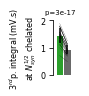

In [136]:
from datavyz import ge

first_observations = np.array(HML['chelatedZn'])/1e3
second_observations = np.array(HML['freeZn'])/1e3
color1=ge.green
color2='dimgrey'
lw=0.2
ylabel='3$^{rd}$p. integral (mV.s)\nat $N_{syn}^{1/2}$ chelated'
xticks_rotation=70

pval = ttest_rel(first_observations, second_observations)[1]

fig_args={'figsize':(.5,1.2), 'right':0}
fig5, ax = ge.figure(**fig_args)
    
for i in range(len(first_observations)):
    ax.plot([0, 1], [first_observations[i], second_observations[i]], '-', lw=lw, color='k')
    
ax.bar([0], [np.mean(first_observations)], yerr=np.std(first_observations), color=color1, lw=lw)
ax.bar([1], [np.mean(second_observations)], yerr=np.std(second_observations), color=color2, lw=lw)

ge.title(ax, 'p=%.0e   ' % pval, size='small')

ge.set_plot(ax, ['left'],
            yticks=[0, 1, 2],
            # ylim = [-.2, 7.2],
            ylabel=ylabel)


In [139]:
ge.multipanel_figure([[fig4, fig5]],
                     LABELS=[['a', 'b']],
                     width='single-column',# mm
                     X = [[20, 130]],
                     Y = [[0, 0]],
                     # X_LABELS = [[0, 90, 370]], Y_LABELS = [[0,0,0]],
                     height=33, # mm
                     export_to_png=True, bg='white',
                     fig_name=os.path.join('figures', 'nmda-event-all.svg'))

RUNNING: inkscape figures\nmda-event-all.svg --export-area-page --export-background="white" --export-type=png --export-filename="figures\nmda-event-all.png" --export-dpi=300
[!!] figures\nmda-event-all.svg not exported as png
